In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import urllib.request, urllib.parse, urllib.error
import os, logging, importlib

from datetime import datetime

importlib.reload(logging)
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(message)s")

In [7]:
HOME_DIR = os.path.expanduser('~')

input_filename = 'Private/Git/Meterstanden/Data/Meterstanden.csv'

In [8]:
dpi = 100
fig_width = 800
fig_height = 600

In [9]:
# Read the input csv file, make the Date_Time column the index column and parse the dates

df = pd.read_csv(os.path.join(HOME_DIR, input_filename), index_col="Date_Time", parse_dates=True)

logging.info("Reading input csv file from {}.".format(input_filename))

df.info()

INFO:Reading input csv file from Private/Git/Meterstanden/Data/Meterstanden.csv.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2015-10-07 12:00:00 to 2018-02-04 09:00:00
Data columns (total 8 columns):
Gas            741 non-null float64
eDag           735 non-null float64
eNacht         760 non-null float64
SMA_3000       793 non-null float64
SMA_7000       793 non-null float64
SMA            581 non-null float64
Temperatuur    741 non-null float64
Water          735 non-null float64
dtypes: float64(8)
memory usage: 57.4 KB


# Gasverbruik

<IPython.core.display.Javascript object>


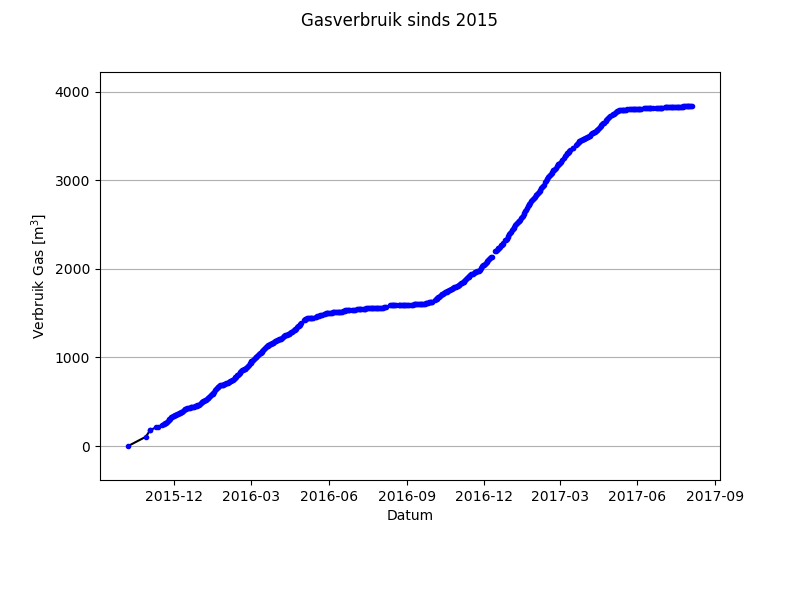

In [20]:
title = "Gasverbruik sinds 2015"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)

# Make space for and rotate the x-axis tick labels

fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)

# Tell matplotlib to interpret the x-axis values as dates

ax.xaxis_date()
ax.yaxis.grid()
ax.plot(df['Gas'], 'k-')
ax.plot(df['Gas'], 'b.')

ax.set_xlabel("Datum")
ax.set_ylabel("Verbruik Gas [m$^3$]")

# Create a 5% (0.05) and 10% (0.1) padding in the
# x and y directions respectively.
plt.margins(0.05, 0.1)

plt.show()


# Gasverbruik per dag

<IPython.core.display.Javascript object>


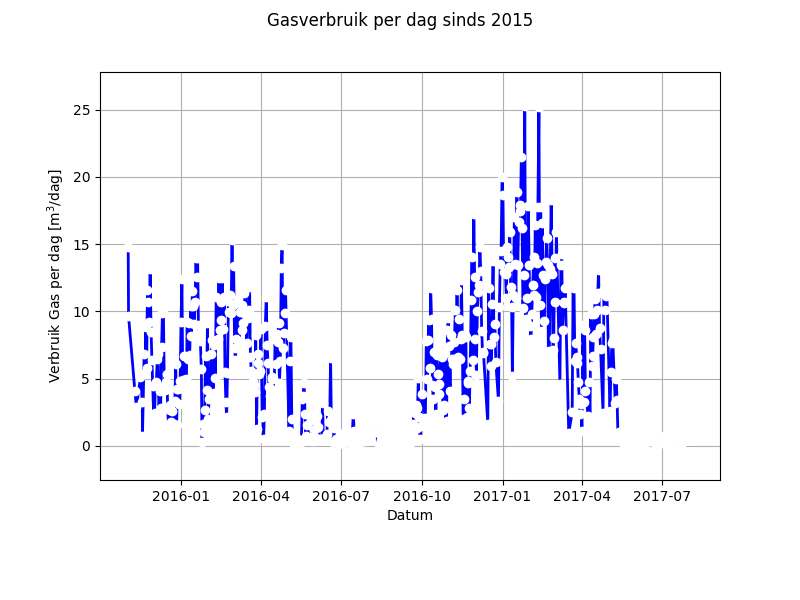

In [21]:
# Bereken het verbruik in gas tussen twee opeenvolgende metingen

g_diff = df['Gas'].diff().dropna()

# Bereken de tijd tussen twee opeenvolgende metingen in dagen (both options are the same)

time_diff_days = g_diff.index.to_series().diff().astype('timedelta64[s]') / 60. / 60. / 24.
time_diff_days = g_diff.index.to_series().diff().dt.total_seconds().fillna(0) / 60. / 60. / 24.

# Bereken het verbruik van gas per dag

g_per_dag = g_diff / time_diff_days

# Prepare and show the plot

title = "Gasverbruik per dag sinds 2015"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)

fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)
ax.xaxis_date()
ax.grid()
ax.set_xlabel("Datum")
ax.set_ylabel("Verbruik Gas per dag [m$^3$/dag]")

ax.plot(g_per_dag, 'k-', linewidth=2.0, color='blue')
ax.plot(g_per_dag, 'wo')

plt.margins(0.05, 0.1)
plt.show()


# Elektriciteitsverbruik

<IPython.core.display.Javascript object>


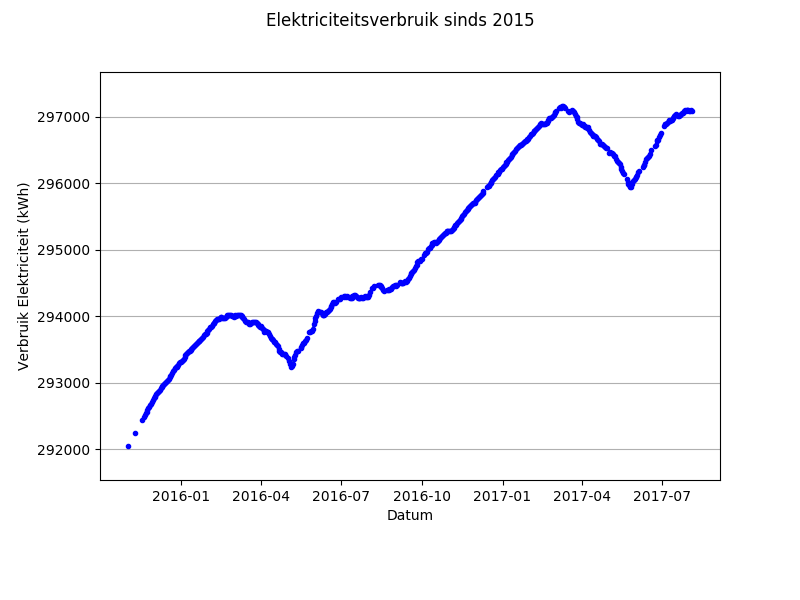

In [22]:
e_total = df['eDag'] + df['eNacht']

title = "Elektriciteitsverbruik sinds 2015"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)
fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)
ax.xaxis_date()
ax.yaxis.grid(True)
ax.set_xlabel("Datum")
ax.set_ylabel("Verbruik Elektriciteit (kWh)")
ax.plot(e_total)
ax.plot(e_total, 'b.')

plt.margins(0.05, 0.1)
plt.show()


# Elektriciteit per dag

Totale opbrengst zonnepanelen op 2017-08-04 06:37:00: 53.137 [kWh]


<IPython.core.display.Javascript object>


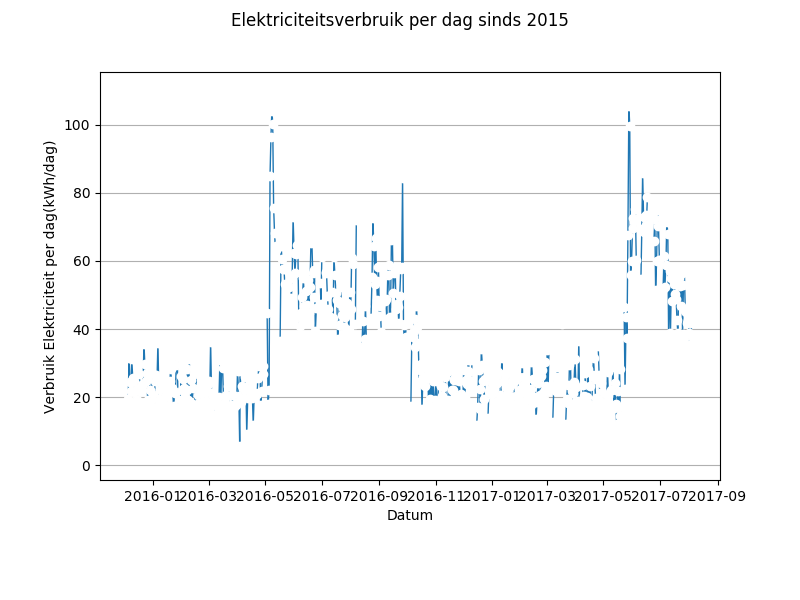

In [23]:
# Bereken het verbruik in elektriciteit tussen twee opeenvolgende metingen
# Elektriciteit voor de dag en nacht teller eerst bijeen tellen

e_total = df.eDag + df.eNacht
e_diff = e_total.diff().dropna()

# Bereken de tijd tussen twee opeenvolgende metingen in dagen

time_diff_days = e_diff.index.to_series().diff().dt.total_seconds().fillna(0) / 60. / 60. / 24.

# Bereken het elektriciteitsverbruik per dag

e_per_dag = e_diff / time_diff_days

# Bereken de totale opbrengst per dag van de zonnepanelen

z_total = df.SMA_3000.shift(1) + df.SMA_7000.shift(1)
z_total = z_total.dropna()

print ("Totale opbrengst zonnepanelen op {}: {} [kWh]".format(z_total.index[-1], z_total[-1]))

# Het totaal verbruik per dag is de sum van het elektriciteitsverbruik en de opbrengst van de zonnepanelen

ez_per_dag = e_per_dag + z_total

# Prepare and show the plot

title = "Elektriciteitsverbruik per dag sinds 2015"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)
fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)
ax.xaxis_date()
ax.yaxis.grid(True)
ax.set_xlabel("Datum")
ax.set_ylabel("Verbruik Elektriciteit per dag(kWh/dag)")
ax.plot(ez_per_dag, linewidth=1)
ax.plot(ez_per_dag, 'wo')

plt.margins(0.05, 0.1)
plt.show()


# Verhouding opbrengst zonnepanelen

<IPython.core.display.Javascript object>


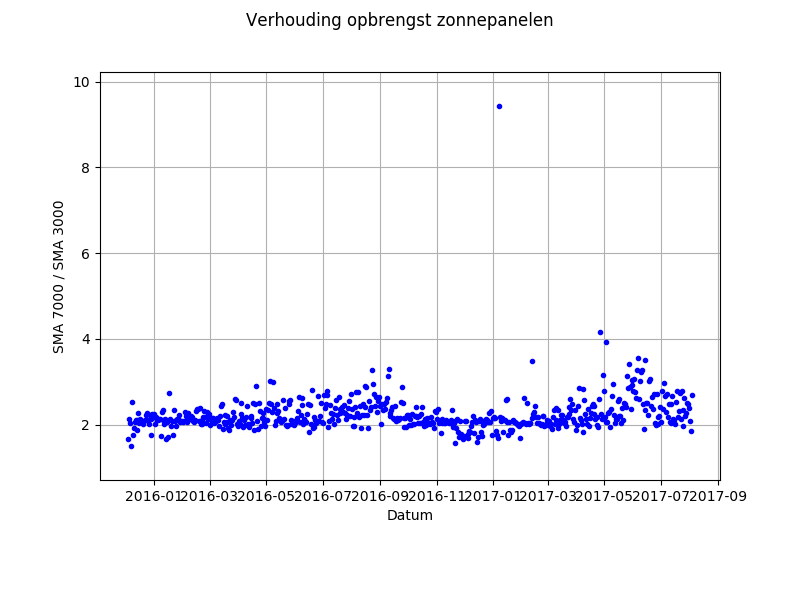

In [24]:
# De SMA 7000 bevat 32 zonnepanelen, de SMA 3000 bevat er 14. De verhouging zou dus ± 2.28 moeten zijn

sma_ratio = df.SMA_7000 / df.SMA_3000

# Prepare and show the plot

title = "Verhouding opbrengst zonnepanelen"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)
fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)
ax.xaxis_date()
ax.grid(True)

ax.set_xlabel("Datum")
ax.set_ylabel("SMA 7000 / SMA 3000")
ax.plot(sma_ratio, "b.")

plt.margins(0.05, 0.1)
plt.show()


In [20]:
dfm = df.groupby(pd.TimeGrouper(freq='M')).sum()
e_total = dfm.SMA_3000 + dfm.SMA_7000
e_total = e_total.dropna()


In [22]:
e_total

Date_Time
2015-12-31     185.248
2016-01-31     213.224
2016-02-29     435.804
2016-03-31     783.291
2016-04-30    1087.096
2016-05-31    1330.062
2016-06-30    1181.291
2016-07-31    1463.865
2016-08-31    1324.027
2016-09-30    1079.541
2016-10-31     521.071
2016-11-30     240.671
2016-12-31     214.159
2017-01-31     258.280
2017-02-28     302.413
2017-03-31     905.447
2017-04-30    1100.676
2017-05-31    1410.653
2017-06-30    1415.807
2017-07-31    1330.676
2017-08-31    1125.552
2017-09-30     894.698
2017-10-31     532.615
2017-11-30     245.691
2017-12-31      93.892
2018-01-31     168.470
2018-02-28      16.559
Freq: M, dtype: float64

<IPython.core.display.Javascript object>


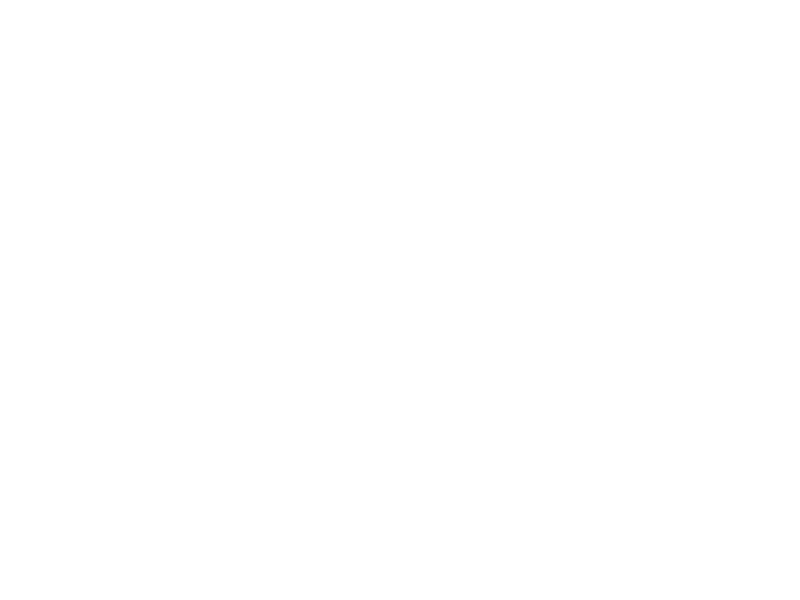

TypeError: bar() missing 1 required positional argument: 'height'

In [25]:
title = "Opbrengst zonnepanelen"
fig = plt.figure(figsize=(fig_width/dpi, fig_height/dpi), dpi=dpi)
fig.suptitle(title)
fig.autofmt_xdate()

ax = fig.add_subplot(1, 1, 1)
ax.xaxis_date()
ax.grid(True)

ax.set_xlabel("Datum")
ax.set_ylabel("SMA 7000 / SMA 3000")
ax.bar(e_total)

plt.margins(0.05, 0.1)
plt.show()



In [28]:
e_total


AttributeError: 'Series' object has no attribute 'x'